Analysis for IndeLLM

In [3]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import data
overall = pd.read_csv("../Results/overall.csv")
alldata = pd.read_csv("../Data/Indel_curated.csv")

overall.head()
alldata.head()

,Unnamed: 0,Id_matching,Feature_x,Consequence_x,Protein_start,Protein_stop,wt,mut,seq,GeneID,...,DDD subset (n=151),CADD,CAPICE,FATHMM-indel,MutPredIndel,MutationTaster2021,PROVEAN,SIFT-indel,VEST-indel,VVP
0,0,0,ENST00000379198.5,inframe_insertion,4,NaN,L,LRRAWR,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,ENSG00000176022,...,No,12.37,0.073788,0.194999931,0.61176,Benign,-3.44,damaging,0.05,7.0
1,1,1,ENST00000379198.5,inframe_deletion,136,139.0,VLAM,V,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,ENSG00000176022,...,No,22.40,0.448487,0.912278105,0.71407,Deleterious,-11.00,damaging,0.23,98.0
2,2,2,ENST00000476993.2,inframe_deletion,61,69.0,VAPLPLGTG,V,MLPWTALGLALSLRLALARSGAERGPPASAPRGDLMFLLDSSASVS...,ENSG00000179403,...,No,21.60,0.570002,0.99589538,0.60790,Deleterious,-27.11,neutral,0.07,100.0
3,3,3,ENST00000404249.8,inframe_deletion,312,314.0,EEE,E,MGDEKDSWKVKTLDEILQEKKRRKEQEEKAEIKRLKNSDDRDSKRD...,ENSG00000008128,...,No,15.81,0.005563,0.466641233,0.11935,Benign,-2.76,neutral,0.10,15.0
4,4,4,ENST00000341426.9,inframe_deletion,445,446.0,EG,G,MEMEQEKMTMNKELSPDAAAYCCSACHGDETWSYNHPIRGRAKSRS...,ENSG00000008130,...,No,6.09,0.001876,0.008217187,0.38066,Benign,-1.90,damaging,0.29,95.0


In [4]:
import numpy as np

#Add indel type (insertion or deletion) info
overall['indel'] = overall.apply(lambda row: 'deletion' if row['length_mut'] < row['length_wt'] else 'insertion', axis=1)

#Add indel length 
overall['length_indel'] = overall.apply(lambda row: row['length_wt'] - row['length_mut'] if row['indel'] == 'deletion' else row['length_mut'] - row['length_wt'], axis=1) 

#Add difference of fitness (positive value positive effect, negative value negative effect)
overall['dif_evo'] = overall['evo_mut'] - overall['evo_wt']
overall['dif_fit'] = overall['fit_mut'] - overall['fit_wt']

#Add a cleaned up labels info
overall['labels_cleaned'] = np.where(overall['label'].str.contains('benign', case=False, na=False), 
                                'Benign', 
                                np.where(overall['label'].str.contains('pathogenic', case=False, na=False), 
                                         'Pathogenic', 
                                         np.nan))

overall.head()

,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label,indel,length_indel,dif_evo,dif_fit,labels_cleaned
0,0,334,329,300.976887,295.771454,183.474468,181.478358,Benign/Likely benign,insertion,5,5.205434,1.996110,Benign
1,1,326,329,289.070291,295.771454,175.395118,181.483721,Pathogenic,deletion,3,-6.701162,-6.088603,Pathogenic
2,2,437,445,394.023689,407.087317,202.841284,211.450276,Likely pathogenic,deletion,8,-13.063628,-8.608993,Pathogenic
3,4,445,446,407.261862,408.398288,197.364461,198.448622,likely benign,deletion,1,-1.136426,-1.084161,Benign
4,5,339,340,279.895415,282.956223,169.600709,175.565114,Pathogenic,deletion,1,-3.060808,-5.964405,Pathogenic


In [5]:
#Calculating the average dif values per bening and pathogenic
evomeanpath = overall[overall['labels_cleaned'] == 'Pathogenic']['dif_evo'].mean()
evomeanbeg = overall[overall['labels_cleaned'] == 'Benign']['dif_evo'].mean()

fitmeanpath = overall[overall['labels_cleaned'] == 'Pathogenic']['dif_fit'].mean()
fitmeanbeg = overall[overall['labels_cleaned'] == 'Benign']['dif_fit'].mean()

print("Evo Model, mean for pathogenic indels:", evomeanpath)
print("Evo Model, mean for begign indels:", evomeanbeg)
print("Fit Model, mean for pathogenic indels:", fitmeanpath)
print("Fit Model, mean for benign indels", fitmeanbeg)

Evo Model, mean for pathogenic indels: -3.6320691402532517
Evo Model, mean for begign indels: -1.2970779419085199
Fit Model, mean for pathogenic indels: -3.4223875154260623
Fit Model, mean for benign indels -0.4614182559092736


Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 0, 'Ids of indels')

Text(0.5, 1.0, 'Evo difference per indel, colored by true labels')

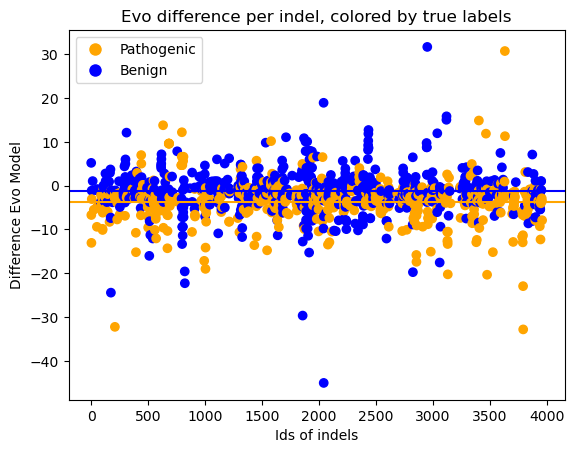

Text(0, 0.5, 'Difference Fit Model')

Text(0.5, 0, 'Ids of indels')

Text(0.5, 1.0, 'Fit difference per indel, colored by true labels')

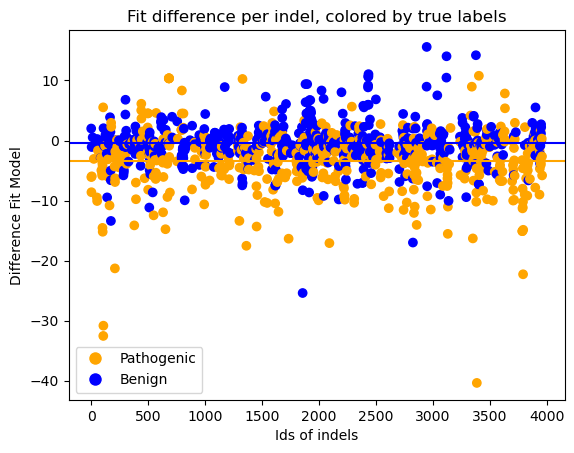

Text(0.5, 0, 'fit')

Text(0, 0.5, 'evo')

Text(0.5, 1.0, 'Comapring the Fit and Evo difference scores, colored by true labels')

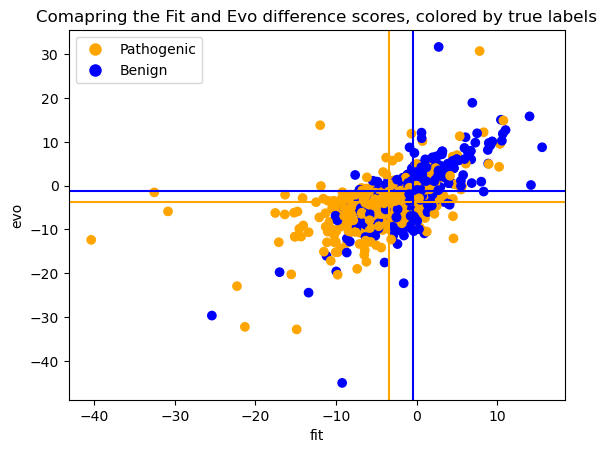

In [6]:
import matplotlib.pyplot as plt

#Creating colors for labels
color_map = {'Pathogenic': 'orange', 'Benign': 'blue'}
colors = overall['labels_cleaned'].map(color_map)
legend_labels = {label: color for label, color in color_map.items() if label in overall['labels_cleaned'].unique()}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
           for label, color in legend_labels.items()]

#Plotting evo scores
plt.scatter(overall['pair_id'],overall['dif_evo'], c=colors)
plt.ylabel('Difference Evo Model')
plt.xlabel('Ids of indels')
plt.title('Evo difference per indel, colored by true labels')
plt.axhline(y=evomeanpath, color = 'orange')
plt.axhline(y=evomeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

#Plotting fit scores
plt.scatter(overall['pair_id'],overall['dif_fit'], c=colors)
plt.ylabel('Difference Fit Model')
plt.xlabel('Ids of indels')
plt.title('Fit difference per indel, colored by true labels')
plt.axhline(y=fitmeanpath, color = 'orange')
plt.axhline(y=fitmeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

#Plotting evo and fit scores together
plt.scatter(overall['dif_fit'], overall['dif_evo'], c=colors)
plt.xlabel('fit')
plt.ylabel('evo')
plt.title('Comapring the Fit and Evo difference scores, colored by true labels')
plt.axhline(y=evomeanpath, color = 'orange')
plt.axhline(y=evomeanbeg, color = 'blue')
plt.axvline(x=fitmeanpath, color = 'orange')
plt.axvline(x=fitmeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

In [7]:
#identifying the low scoring benign
fit_under10 = overall.loc[(overall['labels_cleaned'] == 'Benign') & (overall['dif_fit'] < -10)]
print(fit_under10)

#Partly explained by indel size. Removed indels larger than 10bp
overall_small = overall[overall['length_indel'] < 11]

     pair_id  length_mut  length_wt     evo_mut      evo_wt     fit_mut  \
46       173          65         89   50.657067   75.090821   11.368289   
128      510         104        120   87.960535  103.989124   23.302300   
484     1856         387        419  324.009807  353.677322  132.405266   
817     2824         403        423  330.160794  349.916364  140.703721   
906     3137         457        464  368.514415  375.380665  162.916523   

         fit_wt          label     indel  length_indel    dif_evo    dif_fit  \
46    24.760969  likely benign  deletion            24 -24.433754 -13.392679   
128   34.468675  likely benign  deletion            16 -16.028588 -11.166375   
484  157.797233  likely benign  deletion            32 -29.667515 -25.391967   
817  157.693906  likely benign  deletion            20 -19.755570 -16.990184   
906  172.963818  likely benign  deletion             7  -6.866250 -10.047295   

    labels_cleaned  
46          Benign  
128         Benign  
484  

In [8]:
#Re-calculate a new mean for the small indels
evomeanpathsmall = overall_small[overall_small['labels_cleaned'] == 'Pathogenic']['dif_evo'].mean()
evomeanbegsmall = overall_small[overall_small['labels_cleaned'] == 'Benign']['dif_evo'].mean()
fitmeanpathsmall = overall_small[overall_small['labels_cleaned'] == 'Pathogenic']['dif_fit'].mean()
fitmeanbegsmall = overall_small[overall_small['labels_cleaned'] == 'Benign']['dif_fit'].mean()

#Compare the new means
print("Evo Model, mean for pathogenic indels:", evomeanpath)
print("Evo Model, mean for small pathogenic indels:", evomeanpathsmall)
print("Evo Model, mean for begign indels:", evomeanbeg)
print("Evo Model, mean for small begign indels:", evomeanbegsmall)

print("Fit Model, mean for pathogenic indels:", fitmeanpath)
print("Fit Model, mean for small pathogenic indels:", fitmeanpathsmall)
print("Fit Model, mean for benign indels", fitmeanbeg)
print("Fit Model, mean for small benign indels", fitmeanbegsmall)

Evo Model, mean for pathogenic indels: -3.6320691402532517
Evo Model, mean for small pathogenic indels: -3.624060709764012
Evo Model, mean for begign indels: -1.2970779419085199
Evo Model, mean for small begign indels: -1.0280902817331419
Fit Model, mean for pathogenic indels: -3.4223875154260623
Fit Model, mean for small pathogenic indels: -3.3614013737602804
Fit Model, mean for benign indels -0.4614182559092736
Fit Model, mean for small benign indels -0.359733203802016


Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 0, 'Ids for indels')

Text(0.5, 1.0, 'Evo difference per small indel, colored by true labels')

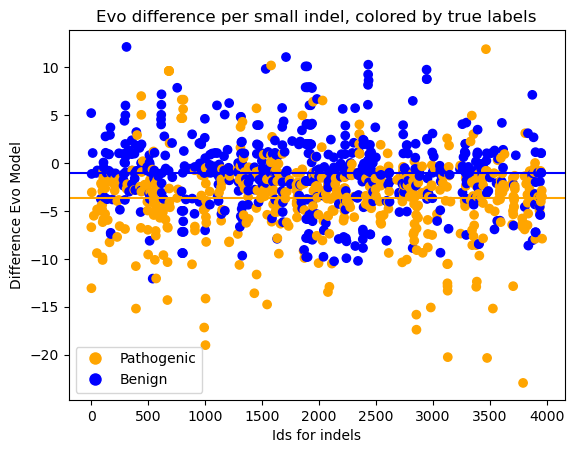

Text(0, 0.5, 'Difference Fit Model ')

Text(0.5, 0, 'Ids for indels')

Text(0.5, 1.0, 'Fit difference per small indel, colored by true labels')

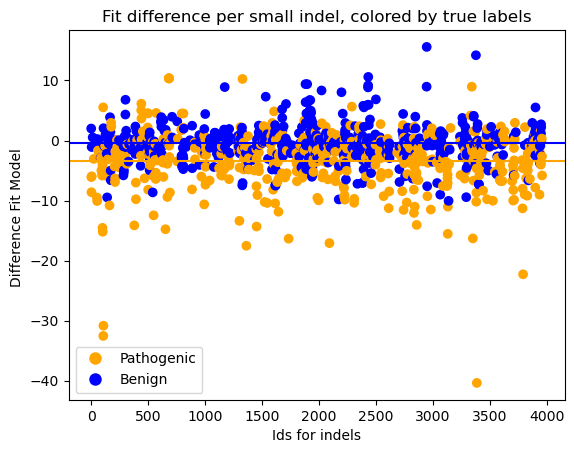

Text(0.5, 0, 'Difference Fit Model')

Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 1.0, 'Comapring the Fit and Evo difference scores for small indels, colored by true labels ')

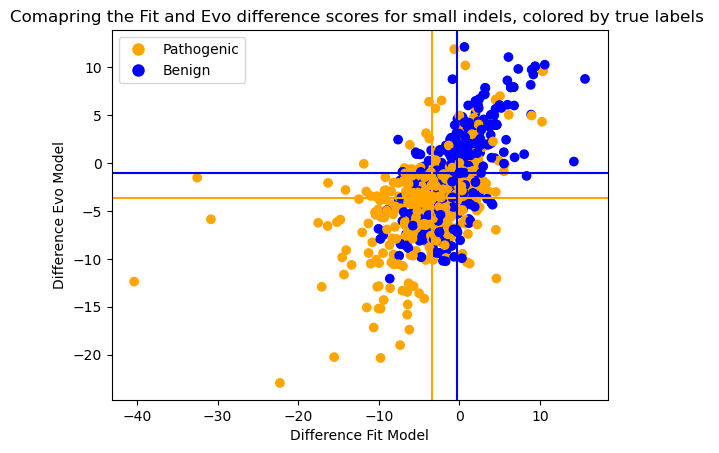

<Axes: xlabel='labels_cleaned', ylabel='dif_evo'>

Text(0.5, 1.0, 'Evo Model')

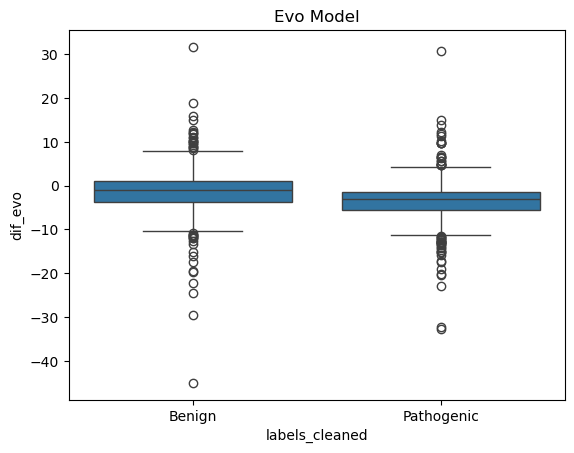

<Axes: xlabel='labels_cleaned', ylabel='dif_fit'>

Text(0.5, 1.0, 'Fit Model')

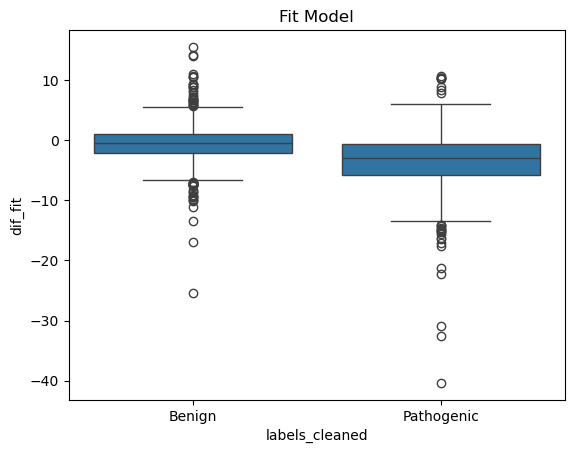

In [9]:
import seaborn as sns
#Plotting for only indels of 10bp or less

#Creating a new colormap for the labels
colors_small = overall_small['labels_cleaned'].map(color_map)
legend_labels_small = {label: color for label, color in color_map.items() if label in overall_small['labels_cleaned'].unique()}
handles_small = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
           for label, color in legend_labels_small.items()]

#Plotting evo scores for small indels
plt.scatter(overall_small['pair_id'],overall_small['dif_evo'], c=colors_small)
plt.ylabel('Difference Evo Model')
plt.xlabel('Ids for indels')
plt.title('Evo difference per small indel, colored by true labels')
plt.axhline(y=evomeanpathsmall, color = 'orange')
plt.axhline(y=evomeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Plotting fit scores for small indels
plt.scatter(overall_small['pair_id'],overall_small['dif_fit'], c=colors_small)
plt.ylabel('Difference Fit Model ')
plt.xlabel('Ids for indels')
plt.title('Fit difference per small indel, colored by true labels')
plt.axhline(y=fitmeanpathsmall, color = 'orange')
plt.axhline(y=fitmeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = "best")
plt.show()

#Plotting fit and evo scores for small indels
plt.scatter(overall_small['dif_fit'], overall_small['dif_evo'], c=colors_small)
plt.xlabel('Difference Fit Model')
plt.ylabel('Difference Evo Model')
plt.title('Comapring the Fit and Evo difference scores for small indels, colored by true labels ')
plt.axhline(y=evomeanpathsmall, color = 'orange')
plt.axhline(y=evomeanbegsmall, color = 'blue')
plt.axvline(x=fitmeanpathsmall, color = 'orange')
plt.axvline(x=fitmeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Also included boxplots
sns.boxplot(x = overall['labels_cleaned'], y = overall['dif_evo'])
plt.title('Evo Model')
plt.show()

sns.boxplot(x = overall['labels_cleaned'], y = overall['dif_fit'])
plt.title('Fit Model')
plt.show()